In [1]:
import os
import sys
os.getcwd()

'c:\\Users\\ebaca\\Desktop\\Phys 417\\Final Project - HEP Tagging'

In [2]:
# importing libraries & making torch.device object for GPU

# neural network packages
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor
from torch.utils.data import DataLoader
sys.path.append('..\\..\\PHYS417_Project')
from nnrunner import NetRunner

# data packages
import numpy as np
import math
import pandas as pd
import sklearn.preprocessing as prep
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import fndict as fd

# visual packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tqdm
import warnings

# Create a torch.device object to tell pytorch where to store your tensors: cpu or gpu
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<b>About the Dataset</b>

<u>Tag</u>: the type of the original particles involved in the collision

<u>Jet</u>: collection of particles that hadronized (decayed) together into a stable particle

Per jet, variable number of constituents (rows) with 5 features (columns):
1. $p_T$: transverse momentum as a fraction of the jet total
2. $\eta$: angular coordinate relative to jet center
3. $\phi$: angular coordinate relative to jet center
4. $E$: energy from constituent
5. $\Delta R = \sqrt{\eta^2 + \phi^2}$

#### Preparing the Data

Normalization: Numerical data should be on a similar scale, typically between 0 and 1. This will help the model learn more efficiently. Use scaling such as Min-Max Scaling or Z-score normalization techniques

Imbalance: If some target classes have significantly more instances than others, the model may become biased towards the majority class. Try over-sampling the minority class or under-sampling the majority class to address this.

Sequence Length Uniformity: Since the sequences have varying lengths, padding or truncation will help to standardize them. This will ensure that the transformer model can handle the input effectively.

In [3]:
# ---- STEP 1: establishing training features (x) and training targets (y) data -----------------------
print("--Establishing Training Features/Targets--")
# while training, model enters in the training features (x) and evaluates against the training targets (y)

''' michael's data extraction: 10,000 final state particles per file and scaled with standard scaler '''

# event data/properties represented by a N x 5 matrix (N = variable number of constituents)
x1 = np.load('..\\..\\PHYS417_Project\\data_1.npz')['x'] 
x2 = np.load('..\\..\\PHYS417_Project\\data_2.npz')['x']
x = np.concatenate((x1, x2), axis=0)

# jet type identifier of a single 5 x 1 binary matrix (0 = no, 1 = yes)
y1 = np.load('..\\..\\PHYS417_Project\\data_1.npz')['y']
y2 = np.load('..\\..\\PHYS417_Project\\data_2.npz')['y']
y = np.concatenate((y1, y2), axis=0)

print("features (x):", x.shape, "\ntargets (y):", y.shape)



# ---- STEP 2: splitting data into training, validation, and testing sets -----------------------------
print("\n --Splitting Data--")

# shuffling for random selection, setting seed to 0 for reproduceability below
x, y = shuffle(x, y, random_state=0) 

# splitting data into training and testing sets
# the testing data is used to evaluate the model's performance after training for predictions on unseen data
# test_size = 0.2 means 20% of the data is for testing and 80% for training
trfeat, tefeat, trtarget, tetarget = train_test_split(x, y, test_size=0.2, random_state=0)

# splitting data again to get validation set
# the validation data is used to visualize/evaluate performance during training to help with tuning 
# 0.25 x 0.8 = 0.2
trfeat, vafeat, trtarget, vatarget = train_test_split(trfeat, trtarget, test_size=0.25, random_state=0) 

print("Training set:", trfeat.shape, trtarget.shape)
print("Validation set:", vafeat.shape, vatarget.shape)
print("Testing set:", tefeat.shape, tetarget.shape)


''' DATA PRE-SCALED, NO NEED TO NORMALIZE '''



# ---- STEP 3: sending to GPU  --------------------------------------------------------------
print("\n --Sending to GPU--")

with warnings.catch_warnings(): # booo warnings
    warnings.simplefilter("ignore")

    trfeat = torch.tensor(torch.from_numpy(trfeat), dtype=torch.float32).to(DEVICE)
    trtarget = torch.tensor(torch.from_numpy(trtarget), dtype=torch.float32).to(DEVICE)

    vafeat = torch.tensor(torch.from_numpy(vafeat), dtype=torch.float32).to(DEVICE)
    vatarget = torch.tensor(torch.from_numpy(vatarget), dtype=torch.float32).to(DEVICE)
    
    tefeat = torch.tensor(torch.from_numpy(tefeat), dtype=torch.float32).to(DEVICE)
    tetarget = torch.tensor(torch.from_numpy(tetarget), dtype=torch.float32).to(DEVICE)

--Establishing Training Features/Targets--
features (x): (20000, 188, 5) 
targets (y): (20000, 5)

 --Splitting Data--
Training set: (12000, 188, 5) (12000, 5)
Validation set: (4000, 188, 5) (4000, 5)
Testing set: (4000, 188, 5) (4000, 5)

 --Sending to GPU--


#### Build Model & Initialize

In [4]:
# ---- BUILDING THE MODEL -----------------------------
class ParticleClassifier(nn.Module):
    def __init__(self,
                 num_encoder_layers,
                 embedding_size,
                 num_heads,
                 num_classes,
                 dim_feedforward=512,
                 dropout=0.1):
        super(ParticleClassifier, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_size,
                                       nhead=num_heads,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout),
            num_layers=num_encoder_layers)
        self.generator = nn.Linear(embedding_size, num_classes)
        # self.positional_encoding = PositionalEncoding(
        #     embedding_size, dropout=dropout)
        # self.adaptive_pool = nn.AdaptiveAvgPool1d(embedding_size)
        self.maxpool = nn.MaxPool1d(embedding_size)

    def forward(self, src, src_mask=None, src_padding_mask=None):
        if src.dim() == 2:
            src = src.unsqueeze(1)
        # src = self.positional_encoding(src)
        outs = self.transformer(src, src_mask, src_padding_mask)
        # return self.generator(outs.mean(dim=1))
        # outs = self.adaptive_pool(outs.transpose(1, 2)).transpose(1, 2)
        outs = self.maxpool(outs.transpose(1, 2)).transpose(1, 2)
        # outs = outs.transpose(1, 2)
        return self.generator(outs.squeeze(1))

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer(self.positional_encoding(src), src_mask)


# ---- INITIALIZING MODEL -----------------------------
classifier = ParticleClassifier(
    num_encoder_layers = 2, # needs to stay 2 or GPU will have memory issues
    embedding_size = 5,  # number of properties per constituent
    num_heads = fd.highest_divisor(5), 
    num_classes = 5,  # number of final state particles
    dim_feedforward = 256, # limit at 512
    dropout = 0.15 # probability of an element to be zeroed
).to(DEVICE)

c:\Users\ebaca\anaconda3\envs\Phys417\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


#### Train Model

<b>Hyperparameters</b>

Fair warning: you might get an "out of memory" error when training. If that happens, try reducing the batch size

betas are hyperparameters that control the exponential moving averages

eps is a small constant added to improve numerical stability by preventing division by zero

In [5]:
epochs = 70
batch_size = 15
learning_rate = 0.002
betas = (0.9, 0.98)
eps = 1e-8

<b>Begin Training with Training Data</b>

In [6]:
from timeit import default_timer as timer

# trfeat = trfeat.float()
trtarget = trtarget.long() # convert to 64-bit integer for CrossEntropyLoss

# vafeat = vafeat.float()
vatarget = vatarget.long()

# tefeat = tefeat.float()
# tetarget = tetarget.long()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate, betas=betas, eps=eps)

# Training Loop ---------------------------------------------------------------------------------------

trlosses = []
valosses = []

print(f'Learning Rate: {learning_rate} \nBatch Size: {batch_size} \nEpochs: {epochs} \n')
with warnings.catch_warnings(): # booo warnings
    warnings.simplefilter("ignore")
    
    start_time = timer()
    for epoch in tqdm.trange(epochs):
        
        optimizer.zero_grad()
        
        train_outputs = classifier(trfeat)
        
        loss = loss_fn(train_outputs, trtarget)
        
        trlosses.append(loss.item())
        
        loss.backward()
        
        optimizer.step()
        
        # Compute Validation Accuracy ----------------------------------------------------------------------
        
        with torch.no_grad(): # Telling PyTorch we aren't passing inputs to network for training purpose
            
            validation_outputs = classifier(vafeat)
            
            correct = (torch.argmax(validation_outputs, dim=1) == 
                    vatarget).type(torch.FloatTensor)
            
            valosses.append(correct.mean())
    end_time = timer()
    time = end_time - start_time
    print(f"Total Train Time: {'{:.0f}m {:.1f}s'.format(*divmod(time, 60))}")

Learning Rate: 0.002 
Batch Size: 15 
Epochs: 70 



100%|██████████| 70/70 [20:18<00:00, 17.41s/it]

Total Train Time: 20m 18.7s


<b>Visualizing the Training</b>

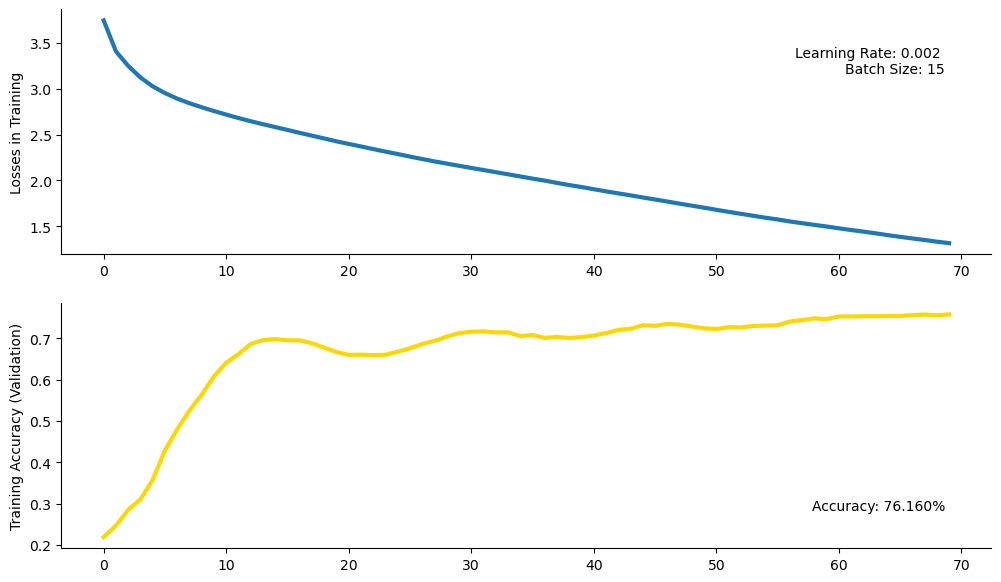

In [7]:
test_outputs = classifier(tefeat)
_ignore_, predicted = torch.max(test_outputs, 1)
correct = (predicted == tetarget).float()
accuracy = correct.mean().item()
# print(f'Test Accuracy: {accuracy*100:.3f}%')

# Plot the loss
plt.figure(figsize = (12, 7))

plt.subplot(2, 1, 1)
plt.plot(trlosses, linewidth = 3)
# plt.plot(runner.losses, linewidth = 3)
plt.ylabel("Losses in Training")
plt.annotate(f'Learning Rate: {learning_rate} \nBatch Size: {batch_size}', xy=(0.95, 0.85), xycoords='axes fraction', va='top', ha='right')
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(valosses, linewidth = 3, color = 'gold')
# plt.plot(runner.accuracies, linewidth = 3, color = 'gold')
plt.ylabel("Training Accuracy (Validation)")
plt.annotate(f'Accuracy: {accuracy*100:.3f}%', xy=(0.95, 0.20), xycoords='axes fraction', va='top', ha='right')
sns.despine()